# Dublin Air Pollution
#### [ Programming for Data Analysis Project GMIT 2020 ]
<br>

<img align="left" width="340" src="http://airtoxenviro.com/wp-content/uploads/2015/05/Power-Plant-Clip-Art.png">

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
_Completed by:_ Olga Rozhdestvina (G00387844@gmit.ie)

___
<br>

## Table of Contents
* [Overview](#overview)
* [General Setup](#setup)
* [Original Data](#original_data)
* [Analysis of the Data Set](#analysis)
    * [Pollutants](#pollutants)
    * [Wind](#wind)
    * [Correlation Between Pollutants (incl AQI) and Wind Speed](#correlation)
* [Distribution Fitting](#dist_fitting)
* [Data Simulation](#data_simulation)

___

<br>

### Overview <a href="overview"></a>

Air pollution is a mixture of solid and gas particles in the air. Every year it causes approximately seven million premature deaths [1]. As air pollution levels increase, there has been a growing interest in modelling the relationship between atmospheric concentration of pollutants and various meteorological conditions in the area studied. [2]

The Air Quality Index, or AQI, is used for measuring the real-time pollution. The higher it is, the greater the level of air pollution. AQI is based on measurement of:

* **NO2** - nitrogen dioxide, 
* **PM10** - particulate matter with a diameter of less than 2.5 micrometers,
* **PM2.5** - particulate matter with a diameter of less than 2.5 micrometers,
* **O3** - ozone,
* **SO2** - sulfur dioxide.

There is a number of meteorological factors that affect AQI. In my analysis I will be looking at wind speed and direction. 

Variables measured for this project: _AQI_ variable is a non-negative integer, _NO2, PM10, PM2.5, O3, SO2, Wind_ are non-negative real numbers with one decimal place and _Wind Direction_ is categorical variable with four possible values: west, north east, north, north west.

> [1] [WHO: Air Pollution](https://www.who.int/health-topics/air-pollution#:~:text=The%20combined%20effects%20of%20ambient,cancer%20and%20acute%20respiratory%20infections.)
<br>
[2] [Joanna A. Kaminska: Probabilistic Forecasting of Nitrogen Dioxide Concentrations at an Urban Road Intersection](https://www.researchgate.net/publication/328978359_Probabilistic_Forecasting_of_Nitrogen_Dioxide_Concentrations_at_an_Urban_Road_Intersection)

___

<br>

### General Setup  <a name="setup"></a>

In [1]:
# Dataframes
import pandas as pd

# Calculations and distributions
import numpy as np

# Distribution fitting.
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# To register the converters
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

%matplotlib inline
register_matplotlib_converters()

In [2]:
# Colour scheme and styles for plots.
sns.set_theme(palette="Set2", context="paper", font_scale=1.5)

# Better sized plots.
plt.rcParams['figure.figsize'] = (13, 9)

___

<br>

### Original Data  <a name="original_data"></a>

I have collected data on air pollution in Dublin for 07/12/2020 from [IQAir](https://www.iqair.com/) - a website of a Swiss air quality technology company. [3] Data on wind speed and direction was collected from [Met Eireann Forecast](https://www.met.ie/) [4]


> [3] [IQAir: Air quality in Dublin](https://www.iqair.com/us/ireland/leinster/dublin)
<br>
[4] [Met Eireann Forecast in Dublin City](https://www.met.ie/weather-forecast/dublin-city#forecasts)

In [3]:
# Simulate the date range
rng = pd.date_range('07/12/2020', periods=24, freq='H')
rng

DatetimeIndex(['2020-07-12 00:00:00', '2020-07-12 01:00:00',
               '2020-07-12 02:00:00', '2020-07-12 03:00:00',
               '2020-07-12 04:00:00', '2020-07-12 05:00:00',
               '2020-07-12 06:00:00', '2020-07-12 07:00:00',
               '2020-07-12 08:00:00', '2020-07-12 09:00:00',
               '2020-07-12 10:00:00', '2020-07-12 11:00:00',
               '2020-07-12 12:00:00', '2020-07-12 13:00:00',
               '2020-07-12 14:00:00', '2020-07-12 15:00:00',
               '2020-07-12 16:00:00', '2020-07-12 17:00:00',
               '2020-07-12 18:00:00', '2020-07-12 19:00:00',
               '2020-07-12 20:00:00', '2020-07-12 21:00:00',
               '2020-07-12 22:00:00', '2020-07-12 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [4]:
# Original data.
raw_data = {'AQI': [84,74,74,72,72,72,72,72,71,72,72,73,80,74,74,74,74,74,74,76,72,76,68,67],
            'NO2': [32.1,29.7,28.5,26.9,26.1,25.8,26.5,27.3,30.9,41.1,52,55.1,58.3,52,41.7,42.6,41.9,38.7,43.1,37.5,32.4,28.7,27.2,20.6],
            'PM2.5': [28,23,23,22.1,22.2,22.1,22,21.9,21.8,22,22.2,22.4,25.9,23,23.1,23.2,23.1,23.1,22.9,24,22.3,24.1,20.1,19.7],
            'PM10': [36,33,28.1,21.2,21.5,19.8,17.1,16.4,15.1,16.6,21.2,28.6,31.1,25.7,25.5,24.4,30.9,25.9,30.9,32.8,30.7,26.6,21.3,18.4],
            'O3': [1,0.4,0.8,0.4,0.3,0.4,0.7,0.3,0,0.6,0.7,0,0.8,0.8,1.8,1.5,1.1,0.8,0.9,0.8,0.7,1.8,3,4.6],
            'SO2': [5,4.2,4.1,3.9,3.7,4.3,4.8,4.2,4.6,6.6,8.2,9.2,10.6,8.6,6.7,6.8,6.9,6,6.3,5,3.6,4.1,4.1,3.4],
            'Wind': [9,9,9,7,7,7,7,7,6,7,7,9,17,15,15,19,13,17,17,19,19,19,19,22],
            'Wind Direction': ['west','west','west','north west','north west','west','north west','north west','north west','north west','north east','north west','north','north','north west','north west','north west','north west','west','west','west','west','west','west']
           }


# Create a dataframe.
df = pd.DataFrame(raw_data, index=rng)

# Display the dataframe.
df

,AQI,NO2,PM2.5,PM10,O3,SO2,Wind,Wind Direction
2020-07-12 00:00:00,84,32.1,28.0,36.0,1.0,5.0,9,west
2020-07-12 01:00:00,74,29.7,23.0,33.0,0.4,4.2,9,west
2020-07-12 02:00:00,74,28.5,23.0,28.1,0.8,4.1,9,west
2020-07-12 03:00:00,72,26.9,22.1,21.2,0.4,3.9,7,north west
2020-07-12 04:00:00,72,26.1,22.2,21.5,0.3,3.7,7,north west
2020-07-12 05:00:00,72,25.8,22.1,19.8,0.4,4.3,7,west
2020-07-12 06:00:00,72,26.5,22.0,17.1,0.7,4.8,7,north west
2020-07-12 07:00:00,72,27.3,21.9,16.4,0.3,4.2,7,north west
2020-07-12 08:00:00,71,30.9,21.8,15.1,0.0,4.6,6,north west
2020-07-12 09:00:00,72,41.1,22.0,16.6,0.6,6.6,7,north west


___

<br>

### Analysis of the data set <a name="analysis"></a>

Prior to visualizing our data it is wise to view our data through some basic statistical details on numerical variables in our data set.

In [5]:
df.describe()

,AQI,NO2,PM2.5,PM10,O3,SO2,Wind
count,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000
mean,73.458333,36.112500,22.80000,24.950000,1.008333,5.620833,12.583333
std,3.387691,10.507609,1.64766,6.052308,1.004302,1.975498,5.428721
min,67.000000,20.600000,19.70000,15.100000,0.000000,3.400000,6.000000
25%,72.000000,27.275000,22.07500,20.850000,0.400000,4.100000,7.000000
50%,73.500000,32.250000,22.65000,25.600000,0.800000,4.900000,11.000000
75%,74.000000,42.075000,23.10000,30.750000,1.025000,6.725000,17.500000
max,84.000000,58.300000,28.00000,36.000000,4.600000,10.600000,22.000000


It is clear from the table above that the highest concentration belongs to _NO2_.

##### Pollutants <a name="pollutants"></a> 

Now let's plot the pollutant concentration in Dublin City on that day. [5]

> [5] [Stack Overflow: Pandas: Sort column by maximum values](https://stackoverflow.com/questions/40111161/pandas-sort-column-by-maximum-values)

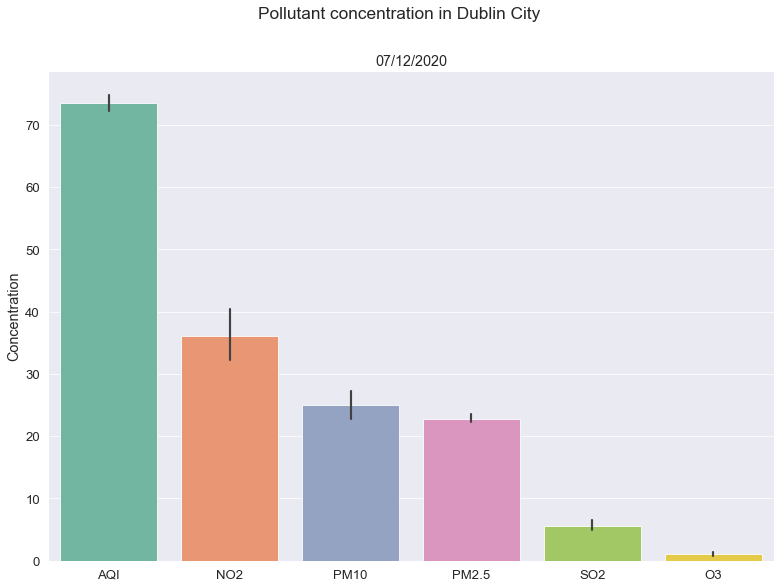

In [6]:
# Separate pollution values.
pollutants = df[['AQI','NO2','PM2.5','PM10','O3','SO2']]

# Sort them by maximum value.
sorted_pol = pollutants.loc[:, pollutants.max().sort_values(ascending=False).index]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Set titles and y label
fig.suptitle("Pollutant concentration in Dublin City")
ax.set_ylabel("Concentration")

# Plot the data ordered by maximum and set a small title.
sns.barplot(data=pollutants, order=list(sorted_pol), ax=ax).set_title("07/12/2020")

# Show plot.
plt.show()

<br>

The plot confirms that the primary pollutant in Dublin is _NO2_. The next in line are _PM10_ and _PM2.5_ , whereas _SO2_ is fairly low and _O3_ is almost non-existent.


Now let's view distribution of each of the pollutants and AQI. [6]

> [6] [Stack Overflow: Matplotlib subplots_adjust hspace so titles and xlabels don't overlap?
](https://stackoverflow.com/questions/2418125/matplotlib-subplots-adjust-hspace-so-titles-and-xlabels-dont-overlap)

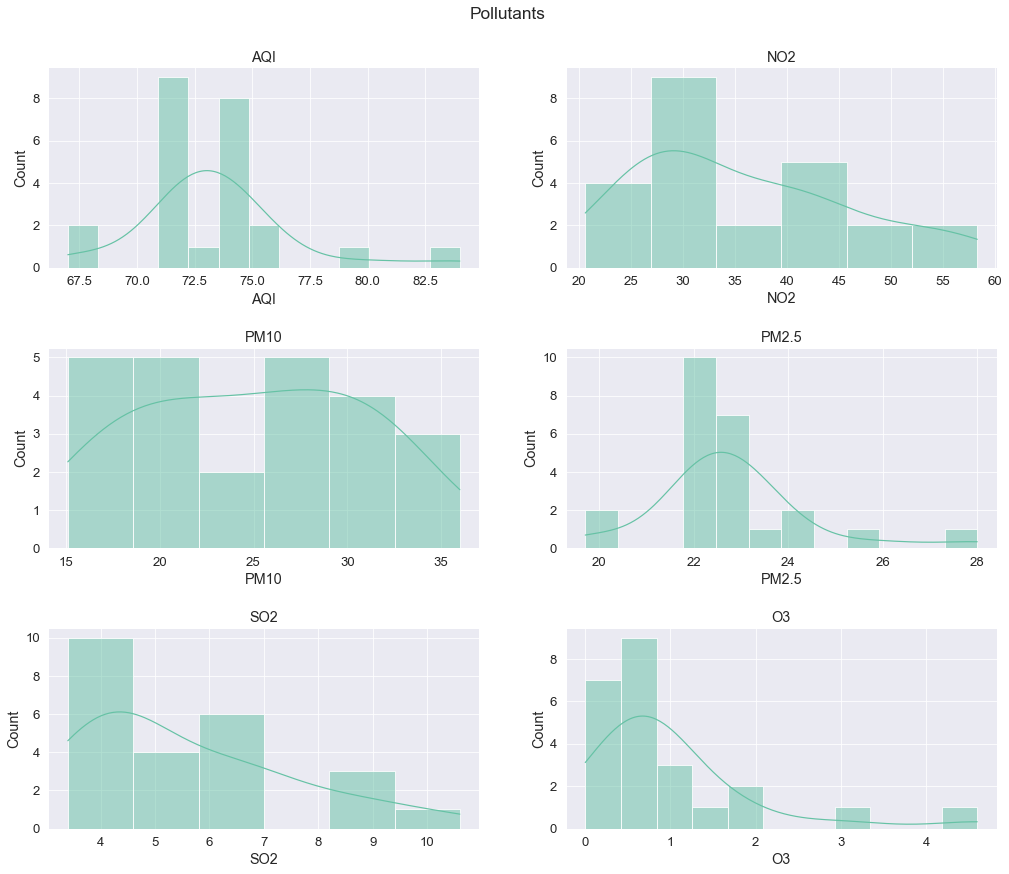

In [7]:
# Create a figure and a set of subplots 3x2 and change plot size.
fig, [[ax1, ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2, figsize=(17,14))

#Set a title.
fig.suptitle("Pollutants", y=0.94)

# Adjust subplots so the title don't overlap
plt.subplots_adjust(hspace=0.4)

def hist(data, ax):
    """ Fuction to build a histogram"""
    # Plot data.
    sns.histplot(df[data], kde=True, ax=ax)
    # Set title.
    ax.set_title(f"{data}")

# Plot the data.
hist('AQI',ax1)
hist('NO2',ax2)
hist('PM10',ax3)
hist('PM2.5',ax4)
hist('SO2',ax5)
hist('O3',ax6)

# Show the plots.
plt.show()

<br>

Judging by the shape of the distribution the data doesn't appear normally distributed and it is not as intuitive to understand which type of distribution will fit any of the variables.

<br>

##### Wind <a name="wind"></a> 

Following the example above, build plots for Wind data.

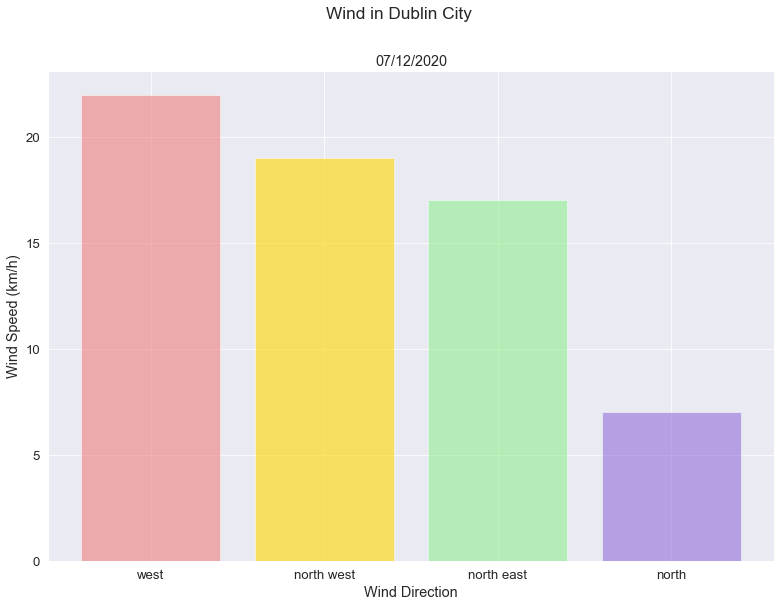

In [8]:
# Separate wind related values.
wind = df[['Wind', "Wind Direction"]]

# Select unique values.
labels = wind["Wind Direction"].unique()

# Calculate maximum speed for each wind drection
west = (wind.loc[wind.loc[:, 'Wind Direction'] == 'west']).max()
north_west = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north west']).max()
north_east = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north east']).max()
north = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north']).max()

# Create an array from the calculations
values = [west[0], north_west[0], north_east[0], north[0]]

# Sort in a descending manner.
values.sort(reverse=True)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Set titles and axis labels
fig.suptitle("Wind in Dublin City")
ax.set_title("07/12/2020")
ax.set_xlabel("Wind Direction")
ax.set_ylabel("Wind Speed (km/h)")

# Plot data.
ax.bar(labels, values, color=['lightcoral', 'gold', 'lightgreen', 'mediumpurple'], alpha=.6)

# Show plot.
plt.show()

<br>

The plot shows that the strongest wind during 7th December was of west direction.

Now let's view how the wind data is distributed.

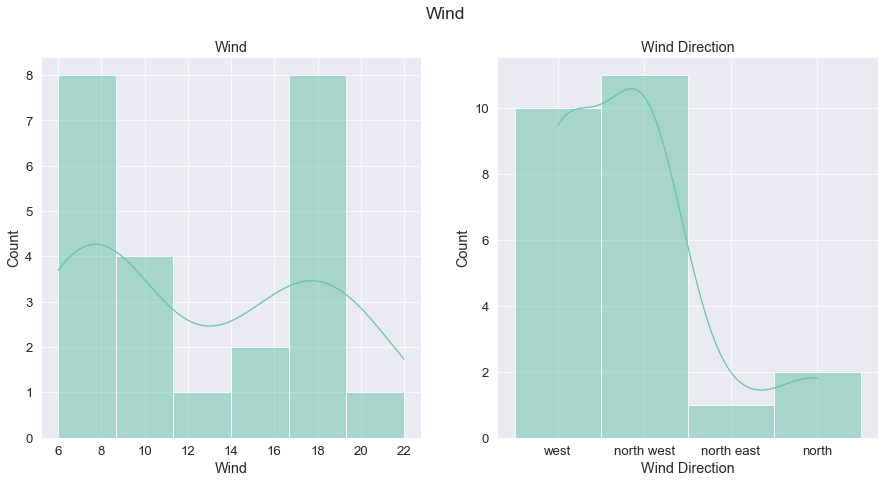

In [39]:
# Create a figure and a set of subplots

fig, [ax1,ax2] = plt.subplots(1,2, figsize=(15, 7))
#Set a title.
fig.suptitle("Wind")

# Plot wind data.
hist("Wind", ax1)
hist("Wind Direction", ax2)


# Show the plot.
plt.show()

<br>

Once again the data plotted above doesn't appear to be normally distributed and without fitting a distribution it is hard to tell which type will be the best fit to the data.


<br>

##### Correlation Between Time of the day and Other variables<a name="correlation_time"></a> 

In statistics, the relationship between two variables is referred to as their correlation. It can be useful in our analysis and modeling to better understand the relationships between pollutant concentration and wind speed. [7] [8]

> [7] [Stack Overflow: how to get ticks every hour?](https://stackoverflow.com/questions/48790378/how-to-get-ticks-every-hour) 
<br>
[8] [Real Python: NumPy, SciPy, and Pandas: Correlation With Python](https://realpython.com/numpy-scipy-pandas-correlation-python/#example-scipy-correlation-calculation)

<br>

* _Pollutants vs Time of the day_

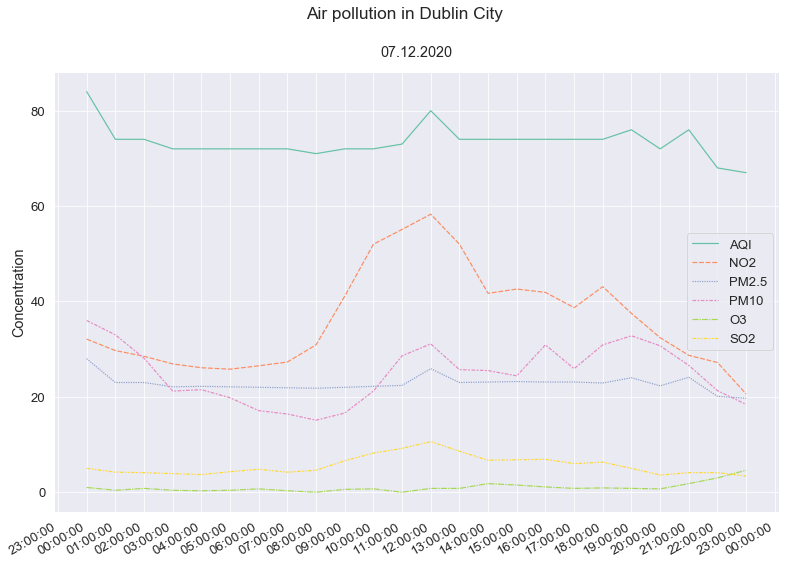

In [10]:
def lineplot(data, suptitle, label):
    """ Building lineplot function """
    
    # Create a figure and a set of subplots.
    fig, ax = plt.subplots()    # Set a title and a label for y axis.
    fig.suptitle(suptitle)
    ax.set_ylabel(label)
    
    # Plot data.
    sns.lineplot(data=data,ax=ax).set_title("07.12.2020", y=1.02)
    
    # Make the x axis display well.
    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H:%M:%S')
    # Tick ax axis.
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)
    # Format.
    fig.autofmt_xdate()
    
    # Show the plot.
    plt.show()

# Plot data for pollutants.
lineplot(pollutants, "Air pollution in Dublin City", "Concentration")   

<br>

The plot depicts relationship between concentration of NO2, PM10 and SO2 and time of the day: it start rising from 7-8 am, reaches its peack at 12 pm and then gain at 6-7 pm and starts falling after 7 pm. 
In my opinion, what explains such trend is that the most of the pollutants in Dublin primarily get in the air from cars, trucks and buses emissions, power plants, and off-road equipment. Thus the pollution concentration rises and falls with traffic.

There are many other factors that influence pollution concentration. For example, PM10 and PM2.5 are both influenced by the atmospheric conditions like wind (we will be looking into it later). Other factors, such as energy consumption and the proportion of electricity consumption contribute to PM2.5 level. [9]


> [9] [Springer Link: Influence of the atmospheric conditions on PM10 concentrations in Poznań, Poland](https://link.springer.com/article/10.1007/s10874-016-9345-5)

<br>

* _Wind speed vs Time of the day_

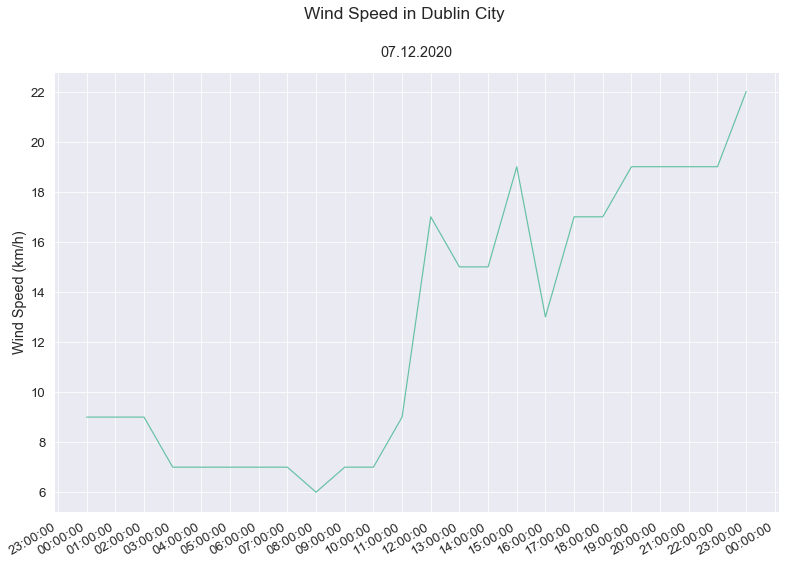

In [11]:
# Call a function to create a plot for wind data.
lineplot(df["Wind"], "Wind Speed in Dublin City", "Wind Speed (km/h)")

<br>

The graph shows that between midnight and 11 am it was time of relatively low wind speeds (below 10 km/h). From 11 am the wind speed continued increasing with a few drops in speed until it reached its peak at 11 pm. 


<br>

##### Correlation Between Pollutants (incl AQI) and Wind Speed  <a name="correlation_wind"></a> 


<br>

* __NO2__

In [12]:
def correlation(pollutant, var):
    """ Correlation calculation """
    # Pearson’s r
    cf1, p1 = stats.pearsonr(df[pollutant], df[var])
    # Spearman’s rho
    cf2, p2 = stats.spearmanr(df[pollutant], df[var])
    # Kendall’s tau
    cf3, p3 = stats.kendalltau(df[pollutant], df[var])
    # print correlation coefficients and p-values to two decimal points.
    print(f"Pearson’s r: {cf1:.2f}, p-value: {p1:.2f}")
    print(f"Spearman’s rho: {cf2:.2f}, p-value: {p2:.2f}")
    print(f"Kendall’s tau: {cf3:.2f}, p-value: {p3:.2f}")

# Calculate correlation between NO2 and Wind Speed.
correlation("NO2", "Wind")

Pearson’s r: 0.12, p-value: 0.59
Spearman’s rho: 0.19, p-value: 0.38
Kendall’s tau: 0.13, p-value: 0.39


In these results, all three correlation coefficients are indicating weak positive relationship between NO2 and wind speed. However, the correlation is not statistically significant since p-value in all three cases is above 0.05 [10] [11]

> [10] [Statistical Help: P Values](https://www.statsdirect.com/help/basics/p_values.htm)
<br>
[11] [Minitab Express Support: Interpret the key results for Correlation](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward)

<br>

* __PM10__

In [13]:
# Calculate correlation between PM10 and Wind Speed.
correlation("PM10", "Wind")

Pearson’s r: 0.36, p-value: 0.08
Spearman’s rho: 0.47, p-value: 0.02
Kendall’s tau: 0.33, p-value: 0.03


Here we can see that Spearman’s and Kendall’s correlation coefficients are statistically significant (with p-value is below 0.05) and both indicate moderate positive relationship between PM10 and wind speed. [11] [12]

> [11] [Stack Overflow: How to Scatter plot or heatmap spearman's correlation in python?](https://stackoverflow.com/questions/62201732/how-to-scatter-plot-or-heatmap-spearmans-correlation-in-python)
<br>
[12] [Stack Exchange: seaborn heatmap not displaying correctly](https://datascience.stackexchange.com/questions/57245/seaborn-heatmap-not-displaying-correctly)

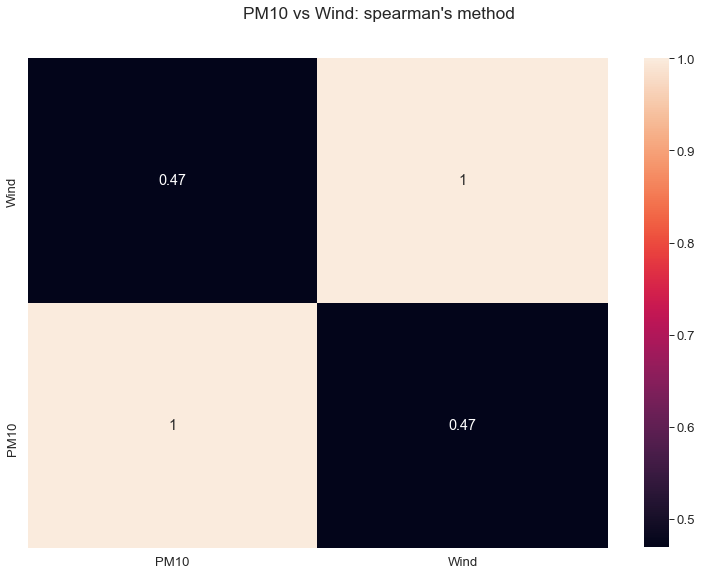

In [14]:
def plot_corr(pollutant, var, method):
    """ Plot correlation heatmap"""
    
    # Create a figure and a set of subplots 
    fig, ax = plt.subplots()
    # Create a data frame for plotting.
    df_corr = pd.DataFrame({pollutant: df[pollutant], var: df[var]})
    # Calculate correlation with pandas
    corr = df_corr.corr(method = method)
    
    # Build a plot.
    sns.heatmap(corr, annot=True, ax=ax)
    
    # Set a title
    fig.suptitle(f"{pollutant} vs {var}: {method}'s method", y=0.96)
    # Set y limits so the annotations are shown correctly 
    plt.ylim(0,2)
    # Show the plot.
    plt.show()
    

# Plot for PM10 vs Wind with Spearman’s method.
plot_corr("PM10", "Wind", "spearman")

<br>

* __PM2.5__

In [15]:
# Calculate correlation between PM2.5 and Wind Speed.
correlation("PM2.5", "Wind")

Pearson’s r: 0.01, p-value: 0.96
Spearman’s rho: 0.39, p-value: 0.06
Kendall’s tau: 0.37, p-value: 0.02


In case of PM2.5, only Kendall's tau is statistically significant and indicate moderate positive relationship with wind speed.

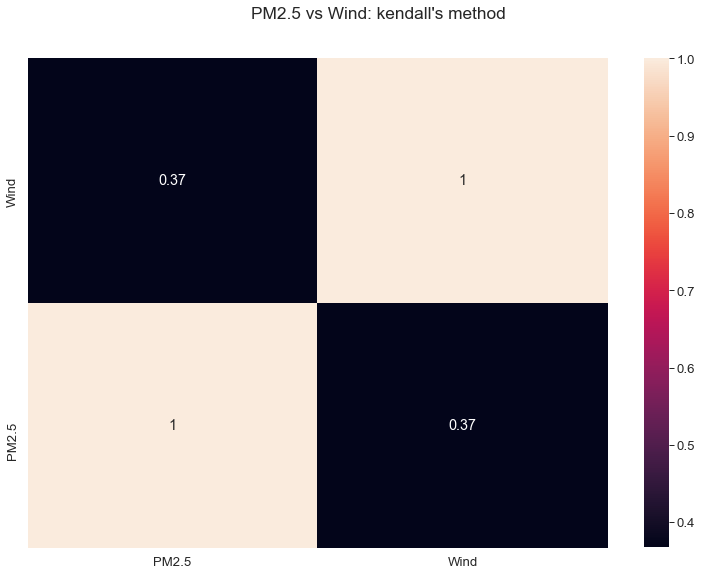

In [16]:
# Plot for PM2.5 vs Wind with Kendall’s method.
plot_corr("PM2.5", "Wind", "kendall")

<br>

* __SO2__

In [17]:
# Calculate correlation between SO2 and Wind Speed.
correlation("SO2", "Wind")

Pearson’s r: 0.06, p-value: 0.79
Spearman’s rho: -0.04, p-value: 0.84
Kendall’s tau: -0.04, p-value: 0.82


None of the above results are statistically significant.

<br>

* __O3__

In [18]:
# Calculate correlation between O3 and Wind Speed.
correlation("O3", "Wind")

Pearson’s r: 0.67, p-value: 0.00
Spearman’s rho: 0.77, p-value: 0.00
Kendall’s tau: 0.62, p-value: 0.00


All three coefficients are showing from strong positive correlation between O3 and wind speed and since the p-value in all three cases is 0.00 the results are statistically highly significant. 

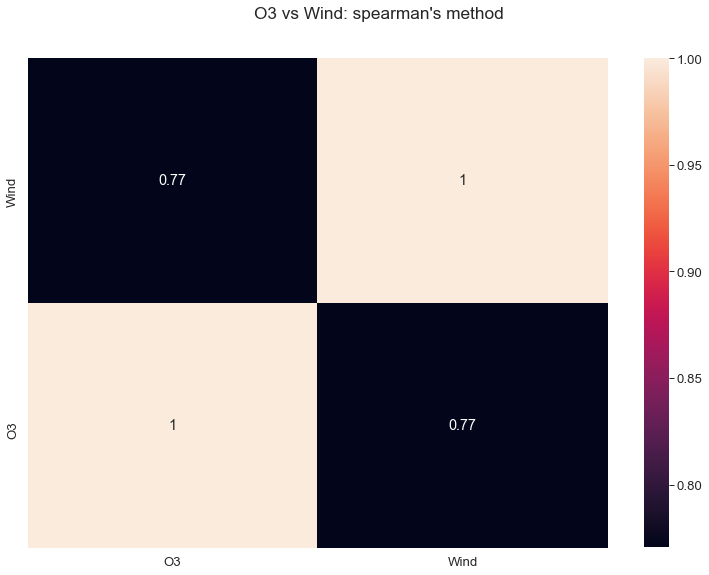

In [19]:
# Plot for O3 vs Wind with Spearman’s method.
plot_corr("O3", "Wind", "spearman")

<br>

* __AQI__

In [20]:
# Calculate correlation between AQI and Wind Speed.
correlation("AQI", "Wind")

Pearson’s r: 0.00, p-value: 0.99
Spearman’s rho: 0.33, p-value: 0.12
Kendall’s tau: 0.34, p-value: 0.04


From the above results the only statistically significant is Kendall’s correlation 0.34, which is an indicator of a moderate positive relationship between the variables.

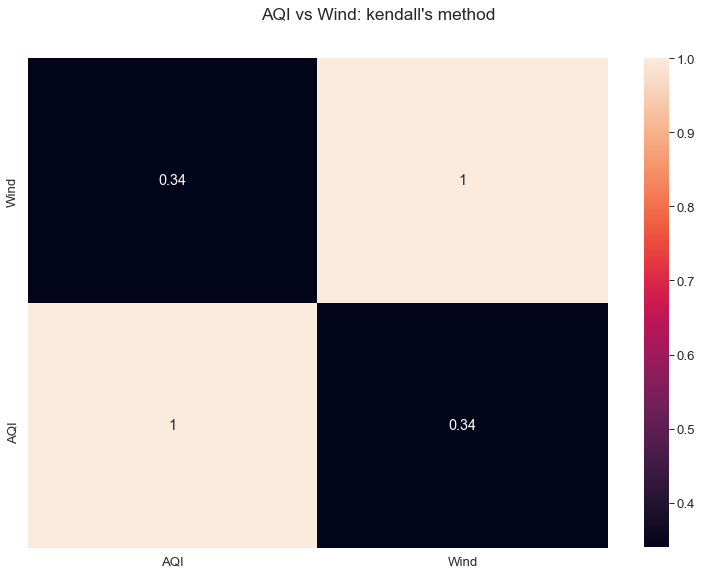

In [21]:
# Plot for AQI vs Wind with Kendall’s method.
plot_corr("AQI", "Wind", "kendall")

___

<br>

### Distribution Fitting <a name=" dist_fitting"></a>

In fitting data on air pollution, there are many acceptable distribution models depending on the areas of study. According to International Journal of Engineering & Technology among the most used distributions are: 
* gamma, 
* lognormal,
* weibull,
* beta,
* gumble.  [13]

However, this is according only to one source. In order to find which distribution fits best our data we should go over the list of available to us distributions and then perform test the goodness of fit. Below I will be using a widely used option Kolmogorov–Smirnov test. [14] [15]

> [13] [International Journal of Engineering & Technology: Fitting Statistical Distribution on Air Pollution: An Overview](https://www.researchgate.net/publication/329267591_Fitting_Statistical_Distribution_on_Air_Pollution_An_Overview)
<br>
[14] [Medium: Distribution Fitting with Python SciPy](https://medium.com/@amirarsalan.rajabi/distribution-fitting-with-python-scipy-bb70a42c0aed)
<br>
[15] [Stack OVerflow: Distribution Fitting with Sum of Square Error (SSE)](https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1)

In [22]:
def fit_dist(data):
    
    """ Fitting distributions function. 
        Performs K-S test and sorts results by lowest stats 
    """
    # List of 87 distribution available on Scipy.
    list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']

    # Create an empty list.
    results = []

    # Loop through each distribution.
    for i in list_of_dists:
        dist = getattr(stats, i)
        # Fit it to the data.
        param = dist.fit(df[data])
        # Perform Kolmogorov–Smirnov test
        a = stats.kstest(df[data], i, args=param)
        # Append results to the list.
        results.append((i,a[0],a[1]))

    # Sort results by the lowest statistic.
    results.sort(key=lambda x:float(x[2]), reverse=True)
    # Return only first 5 results.
    for j in results[:5]:
        # Print results.
        print(f"{j[0]}: statistic={j[1]}, pvalue={j[2]}")

In [23]:
def make_pdf(dist, params, size=8760):
    """Generate distributions's Probability Distribution Function"""

    # Separate parts of parameters.
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get start and end points of distribution.
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series.
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [24]:
def plot_data_with_pdf_fitted(data, dist):
    """Plot generation """

    # Fit distribution.
    params = dist.fit(df[data])
    
    # Call a function to make PDF
    pdf = make_pdf(dist, params)
    # Plot it
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    ax.set_title(f"{data}")
    # Plot the data on the same axis.
    df[data].plot(kind='hist', density=True, alpha=0.5, label='Data', legend=True, ax=ax)
    
    # Show the plot.
    plt.show()

<br>

* __AQI__ 

In [25]:
%%capture --no-stdout

# Fit distributions to AQI
fit_dist("AQI")

laplace: statistic=0.17604399988392794, pvalue=0.40301060386742177
johnsonsu: statistic=0.18763881490496703, pvalue=0.32619168218993855
hypsecant: statistic=0.18963645012427643, pvalue=0.31409709896584626
loglaplace: statistic=0.18993290789719824, pvalue=0.3123302416861034
foldcauchy: statistic=0.1951248865529729, pvalue=0.28254596858308056


We can see that __laplace__ distribution will fit AQI data best. Let's import the distribution and then buid a plot.

In [26]:
# Import laplace distribution
from scipy.stats import laplace

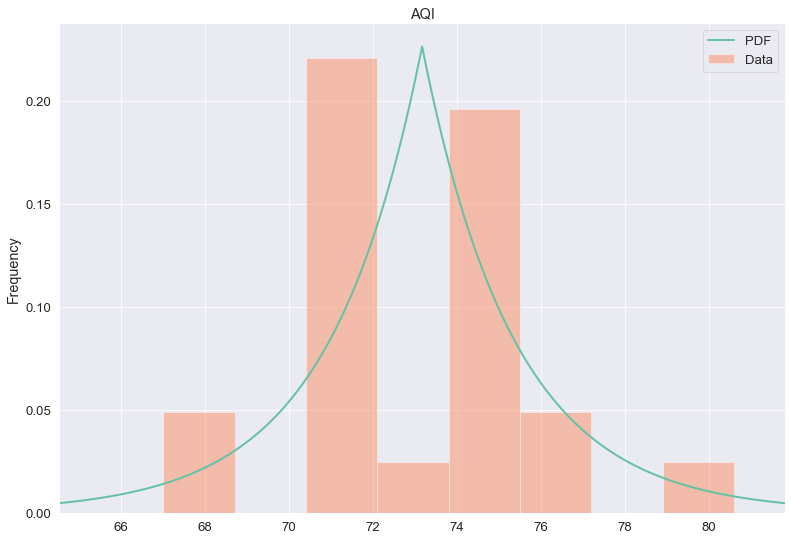

In [27]:
# Plot AQI with laplace distribution fitted.
plot_data_with_pdf_fitted("AQI", laplace)

<br>

* __NO2__ 

In [28]:
%%capture --no-stdout

# Fit distributions to NO2
fit_dist("NO2")

pearson3: statistic=0.11006390814551326, pvalue=0.9332460865429394
chi2: statistic=0.11006421114138942, pvalue=0.93324471072411
gamma: statistic=0.11006468221121257, pvalue=0.9332425716971462
erlang: statistic=0.11006485134136934, pvalue=0.9332418037039794
recipinvgauss: statistic=0.11601677955935441, pvalue=0.9032022624029075


For NO2 the best fitting distribution is __pearson3__.

In [29]:
# Import pearson3 distribution
from scipy.stats import pearson3

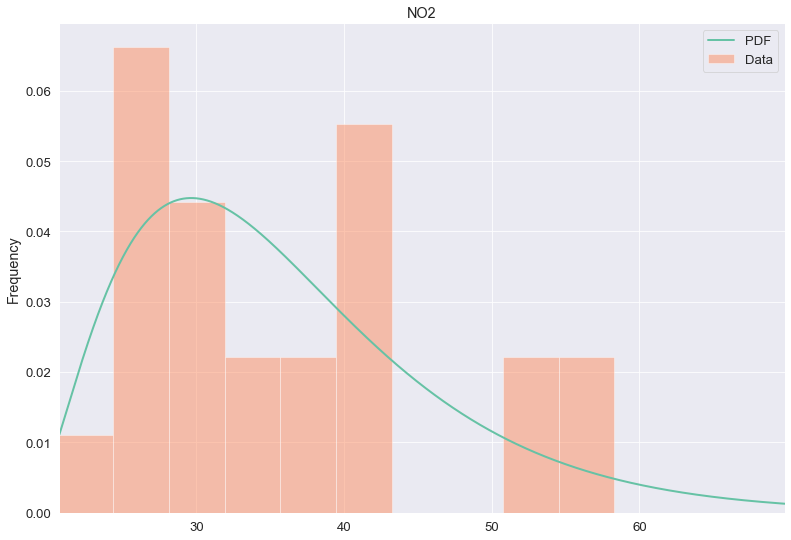

In [30]:
# Plot NO2 with pearson3 distribution fitted.
plot_data_with_pdf_fitted("NO2", pearson3)

<br>

* __PM10__ 

In [31]:
%%capture --no-stdout

# Fit distributions to PM10
fit_dist("PM10")

johnsonsb: statistic=0.09105533900868285, pvalue=0.9885954557380542
gausshyper: statistic=0.09302889934088848, pvalue=0.9855190203001372
beta: statistic=0.1035661252634218, pvalue=0.9590356769977738
uniform: statistic=0.11044657097288674, pvalue=0.931495801760645
powerlognorm: statistic=0.1154080644025332, pvalue=0.9065439772526485


In [32]:
# Import johnsonsb distribution
from scipy.stats import johnsonsb

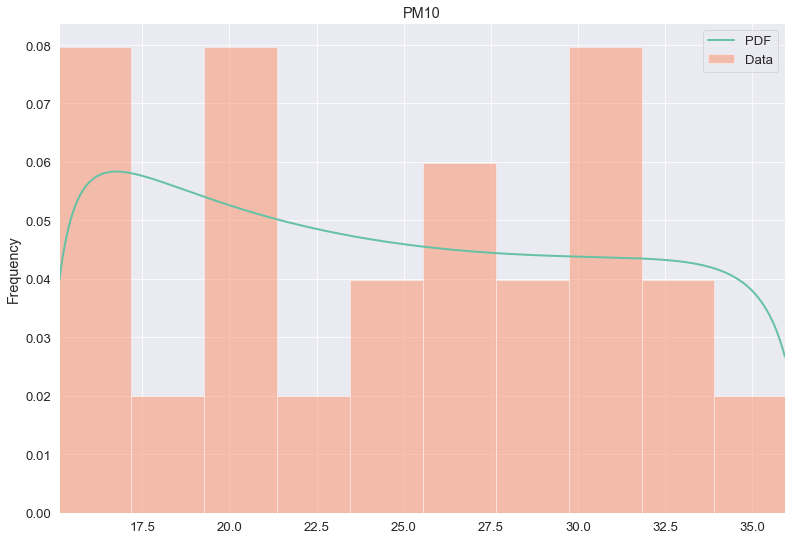

In [33]:
# Plot PM10 with johnsonsb distribution fitted.
plot_data_with_pdf_fitted("PM10", johnsonsb)

<br>

* __PM2.5__ 

In [34]:
%%capture --no-stdout

# Fit distributions to PM2.5
fit_dist("PM2.5")

laplace: statistic=0.14704364175048057, pvalue=0.6451409498854047
johnsonsu: statistic=0.14848966917551953, pvalue=0.6314147682634358
dweibull: statistic=0.15195030567570417, pvalue=0.5992480777974585
hypsecant: statistic=0.15195934006760087, pvalue=0.5991653771571748
foldcauchy: statistic=0.15610214243695786, pvalue=0.5619504957324818


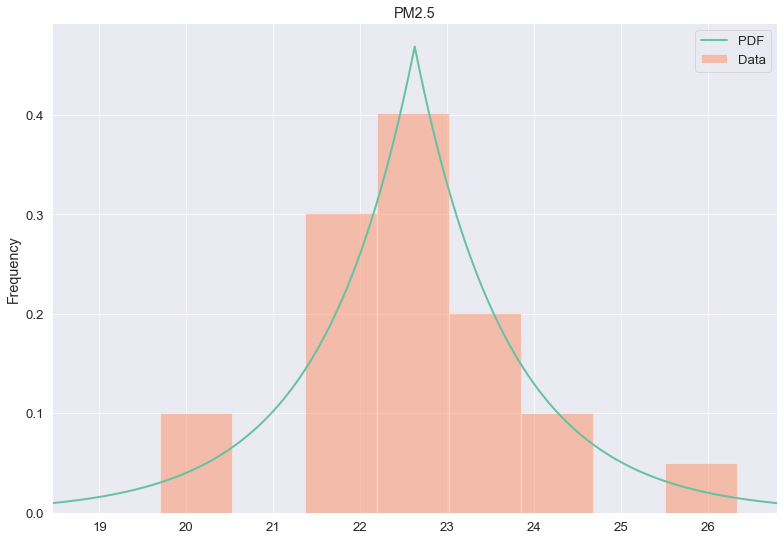

In [35]:
# Plot PM2.5 with laplace distribution fitted.
plot_data_with_pdf_fitted("PM2.5", laplace)

<br>

* __Wind__

In [36]:
%%capture --no-stdout

# Fit distributions to Wind
fit_dist("Wind")

johnsonsb: statistic=0.16838867342838484, pvalue=0.46002426320186907
dweibull: statistic=0.1690128430985166, pvalue=0.4551875281914068
powerlaw: statistic=0.17054327497168503, pvalue=0.443469227822424
nakagami: statistic=0.1744468553474331, pvalue=0.4144901007243314
lomax: statistic=0.176770222244926, pvalue=0.3978632742012152


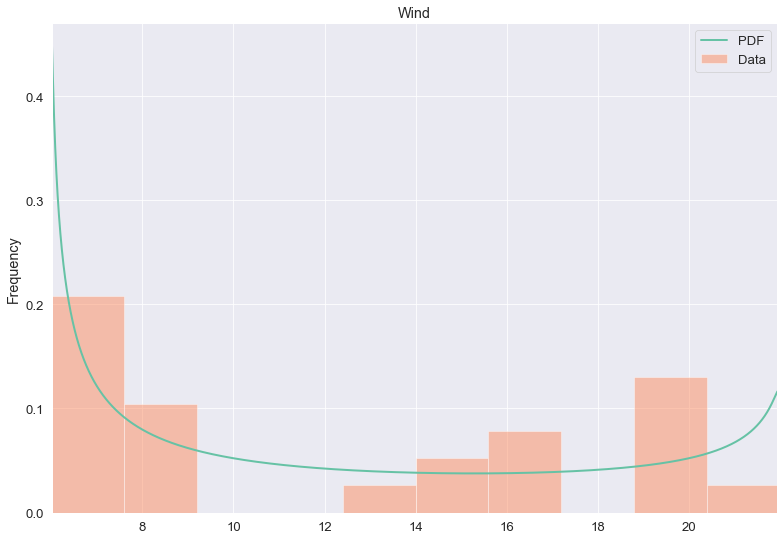

In [37]:
# Plot Wind with johnsonsb distribution fitted.
plot_data_with_pdf_fitted("Wind", johnsonsb)

___

<br>

### Data Simulation <a name="data_simulation"></a>